# Demo showing how to regrid tracks pixel cloudmask to ERA5 resolution

Uses ideas from `regrid_mask.ipynb`, as applied to real data.

In [1]:
import datetime as dt
from pathlib import Path

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe

from mcs_prime import PATHS, McsTracks
%matplotlib notebook

In [2]:
tracks = tracks = McsTracks.load(PATHS['statsdir'] / 'mcs_tracks_final_extc_20190101.0000_20200101.0000.nc', 
                                 PATHS['pixeldir'])
tracks

McsTracks[2019-01-01 00:30:00, 2019-12-31 22:30:00, ntracks=32843]

In [3]:
figdir = PATHS['figdir'] / 'tmp/regrid_pixel_to_era5'
figdir.mkdir(exist_ok=True, parents=True)

In [4]:
# Caches various netcdf fields for faster reruns.
native_path = figdir / 'cloudnumber_native_grid.nc'
mask_path = figdir / 'cloudnumber_ERA5_grid.nc'
regridder_path = figdir / 'bilinear_1200x3600_481x1440_peri.nc'

def clear_cache(paths):
    for path in [p for p in paths if p.exists()]:
        print(f'rm {path}')
        path.unlink()
        
# clear_cache([native_path, mask_path, regridder_path])

In [5]:
time = dt.datetime(2019, 1, 5, 0, 30)
pdtime = pd.Timestamp(time)

In [6]:
ts = tracks.tracks_at_time(time)
frame = ts.pixel_data.get_frame(time)
tmask = (ts.dstracks.base_time == pdtime).values
cns = ts.dstracks.cloudnumber.values[tmask]
cns.sort()

In [7]:
year = 2019
month = 1
day = 5
e5datadir = PATHS['era5dir'] / f'data/oper/an_ml/{year}/{month:02d}/{day:02d}'
e5u = xr.open_dataarray(e5datadir / f'ecmwf-era5_oper_an_ml_{year}{month:02d}{day:02d}0000.u.nc')
e5u = e5u.sel(latitude=slice(60, -60)).sel(level=137).isel(time=0)
pixel_precip = frame.dspixel.precipitation.isel(time=0)

In [8]:
# N.B. caching values.
if regridder_path.exists():
    print('loading regridder')
    regridder = xe.Regridder(pixel_precip, e5u, 'bilinear', periodic=True,
                             reuse_weights=True, weights=regridder_path)
else:
    # N.B. this is reasonably challenging.
    # * lat direction is different,
    # * ERA5 lon: 0--360, pixel lon: -180--180.
    print('generating regridder')
    regridder = xe.Regridder(pixel_precip, e5u, 'bilinear', periodic=True)
    regridder.to_netcdf(regridder_path)
regridder

loading regridder


/home/users/mmuetz/miniconda3/envs/mcs_prime_env/lib/python3.10/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_1200x3600_481x1440_peri.nc 
Reuse pre-computed weights? True 
Input grid shape:           (1200, 3600) 
Output grid shape:          (481, 1440) 
Periodic in longitude?      True

In [9]:
if native_path.exists():
    print('loading native cn data')
    cn_na = xr.open_dataarray(native_path)
else:
    frame.dspixel.cloudnumber.isin(cns).to_netcdf(native_path)

loading native cn data


In [10]:
if mask_path.exists():
    print('loading era5 cn data')
    cn_e5 = xr.open_dataarray(mask_path)
else:
    print('generating era5 cn data')
    mask_regridded = []
    for i in cns:
        print(i)
        mask_regridded.append(regridder((frame.dspixel.cloudnumber == i).astype(float)))

    da_mask_regridded = xr.concat(mask_regridded, pd.Index(cns, name='cn'))
    cn_e5 = ((da_mask_regridded > 0.5).astype(int) * da_mask_regridded.cn).sum(dim='cn')
    cn_e5.to_netcdf(mask_path)

loading era5 cn data


<IPython.core.display.Javascript object>


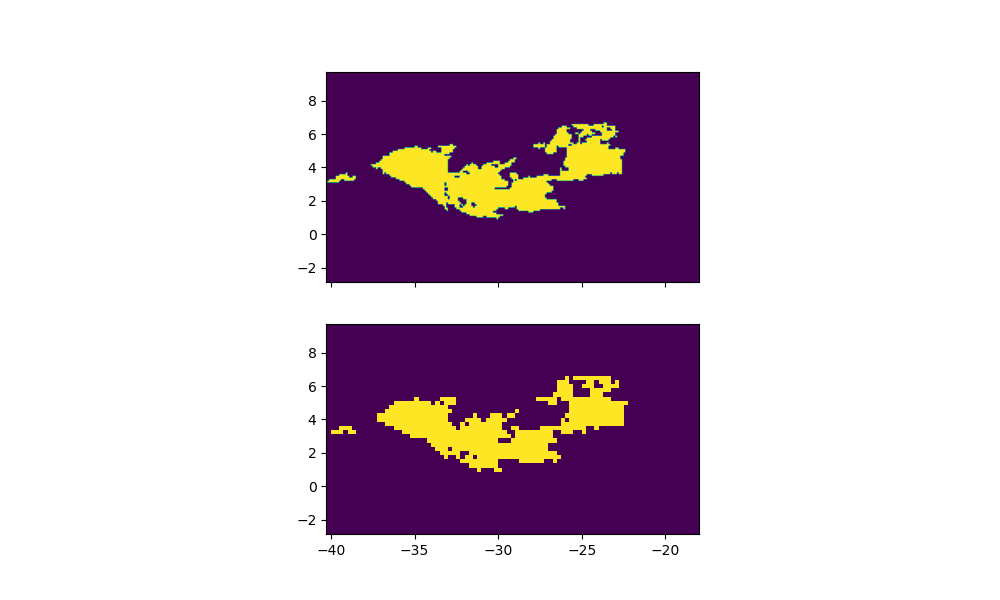

In [11]:
cn_e5 = xr.open_dataarray(mask_path)
cn_na = xr.open_dataarray(native_path)
# (cn_e5 >= 1).plot()
fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True, sharey=True)
fig.set_size_inches(10, 6)

ax0.imshow(cn_na.values[0] > 0, extent=(-180, 180, -60, 60), origin='lower')
ax1.imshow(np.roll(cn_e5.values[0] > 0, 720, axis=1), extent=(-180, 180, -60, 60));
# N.B. Zoomed in on specific cloud mask to show interp.